In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
# Standards
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 200
matplotlib.rcParams['lines.linewidth'] = 1

In [3]:
#Constants
eta0 = 50 #m
a0 = 200e3 #m
L = 1e7 #m
H = 1000 #m
g = 10 #m/s

# Calculating Pahse speed: answer to a)
c = np.sqrt(g * H)

#Calculating time needed: answer to b)
T=L/c

In [40]:
def fin_diff(u10,u01,u12,h10,h01,h12,dt,dx):
    '''
    C-time-space
    start both at index 1
    '''
    u21=u01-g*dt*((h12-h10)/dx)
    h21=h01-H*dt*((u12-u10)/dx)
    return u21,h21

def get_pred(u10, u11, u12, h10, h11, h12, dt, dx):
    Fu = - g * (h12 - h10) / (2 * dx)
    Fh = - H * (u12 - u10) / (2 * dx)
    u21 = u11 + dt * Fu
    h21 = h11 + dt * Fh
    return u21, h21

def heun(u10, u11, u12, h10, h11, h12, dt, dx, upred0, upred2, hpred0, hpred2):
    Fu = - g * (h12 - h10) / (2 * dx)
    Fh = - H * (u12 - u10) / (2 * dx)
    Fupred = - g * (hpred2 - hpred0) / (2 * dx)
    Fhpred = - H * (upred2 - upred0) / (2 * dx)
    u21 = u11 + dt * (Fupred + Fu) / 2
    h21 = h11 + dt * (Fhpred + Fh) / 2
    return u21, h21

def do_heun(u0,h0,dt,dx, t_arr, x_arr):
    u=np.zeros((len(t_arr), len(x_arr)))
    h=np.zeros((len(t_arr), len(x_arr)))
    u_pred = np.zeros(len(x_arr))
    h_pred = np.zeros(len(x_arr))
    u[0] = u0
    h[0] = h0
    # initialize just no movement at beginning, can we assume that at t=1 there is also no movement? because u[1]=t1 right?
    u[1] = u0
    h[1] = h0
    
    for tidx, (ut, ht) in enumerate(zip(u,h)):
        if tidx == len(u)-1:
            break
        if tidx == 0:
            continue
        for xidx, (ux, hx) in enumerate(zip(ut,ht)):
            if xidx == len(ut)-1:
                u12 = u[tidx,0]
                h12 = h[tidx,0]
            else:
                u12 = u[tidx, xidx+1]
                h12 = h[tidx, xidx+1]
            u10 = u[tidx, xidx-1]
            h10 = h[tidx, xidx-1]
            u11 = ux
            h11 = hx

            u21_pred, h21_pred = get_pred(u10, u11, u12, h10, h11, h12, dt, dx)
            u_pred[xidx] = u21_pred
            h_pred[xidx] = h21_pred
            
        for xidx, (ux, hx) in enumerate(zip(ut,ht)):
            if xidx == len(ut)-1:
                upred2 = u_pred[0]
                hpred2 = h_pred[0]
                u12 = u[tidx,0]
                h12 = h[tidx,0]
            else:
                upred2 = u_pred[xidx+1]
                hpred2 = h_pred[xidx+1]
                u12 = u[tidx, xidx+1]
                h12 = h[tidx, xidx+1]
            u10 = u[tidx, xidx-1]
            h10 = h[tidx, xidx-1]
            upred0 = u_pred[xidx-1]
            hpred0 = h_pred[xidx-1]
            u11 = ux
            h11 = hx
            u21, h21 = heun(u10, u11, u12, h10, h11, h12, dt, dx, upred0, upred2, hpred0, hpred2)
            u[tidx+1,xidx] = u21
            h[tidx+1,xidx] = h21
            
    return u,h
    
def do_fin_diff(u0,h0,dt,dx, t_arr, x_arr):
    u=np.zeros((len(t_arr), len(x_arr)))
    h=np.zeros((len(t_arr), len(x_arr)))
    u[0] = u0
    h[0] = h0
    # initialize just no movement at beginning, can we assume that at t=1 there is also no movement? because u[1]=t1 right?
    u[1] = u0
    h[1] = h0
    
    for tidx, (ut, ht) in enumerate(zip(u,h)):
        if tidx == len(u)-1:
            break
        for xidx, (ux, hx) in enumerate(zip(ut,ht)):
            if xidx == len(ut)-1:
                u12 = u[tidx,0]
                h12 = h[tidx,0]
            else:
                u12 = u[tidx, xidx+1]
                h12 = h[tidx, xidx+1]
            u10 = u[tidx, xidx-1]
            h10 = h[tidx, xidx-1]
            u01 = u[tidx-1, xidx]
            h01 = h[tidx-1, xidx]
            if tidx == 0:
                break # to skip euler for now
                u21,h21 = Euler(ux,u10,u12,hx,h10,h12,dt,dx)
                u[tidx+1,xidx] = u21
                h[tidx+1,xidx] = h21
            else:
                u21, h21 =fin_diff(u10,u01,u12,h10,h01,h12,dt,dx)
                u[tidx+1,xidx] = u21
                h[tidx+1,xidx] = h21
    return u,h

In [41]:
# varying grid point amount: anwer to c)

# Numerics Parameters
dt = 50 #s
t_arr = np.arange(0, T + dt, dt)

dx_arr_c = [10000, 20000, 50000, 100000] # m, 100-1000 gridpoints
u_arr_c = []
h_arr_c = []
x_arr_c = []

# for matsuno
umats_arr_c = []
hmats_arr_c = []

#Initialising arrays
for dx in dx_arr_c:
    x_arr = np.arange(-L/2, L/2, dx) #Periodic boundaries so no L+dx
    #Initial speed and height profile
    u0 = np.zeros(len(x_arr))
    h0 = np.zeros(len(x_arr))
    h0[x_arr < -5000e3] = H
    h0[x_arr >= -5000e3] = H + eta0 * np.exp(-(x_arr[x_arr >= -5000e3]/a0)**2)
    h0[x_arr > 5000e3]= H
    
    u, h = do_fin_diff(u0,h0,dt,dx, t_arr, x_arr)
    umats, hmats = do_heun(u0,h0,dt,dx, t_arr, x_arr)
    
    u_arr_c.append(u)
    h_arr_c.append(h)
    umats_arr_c.append(umats)
    hmats_arr_c.append(hmats)
    x_arr_c.append(x_arr)
    

Text(0, 0.5, 'Height in m')

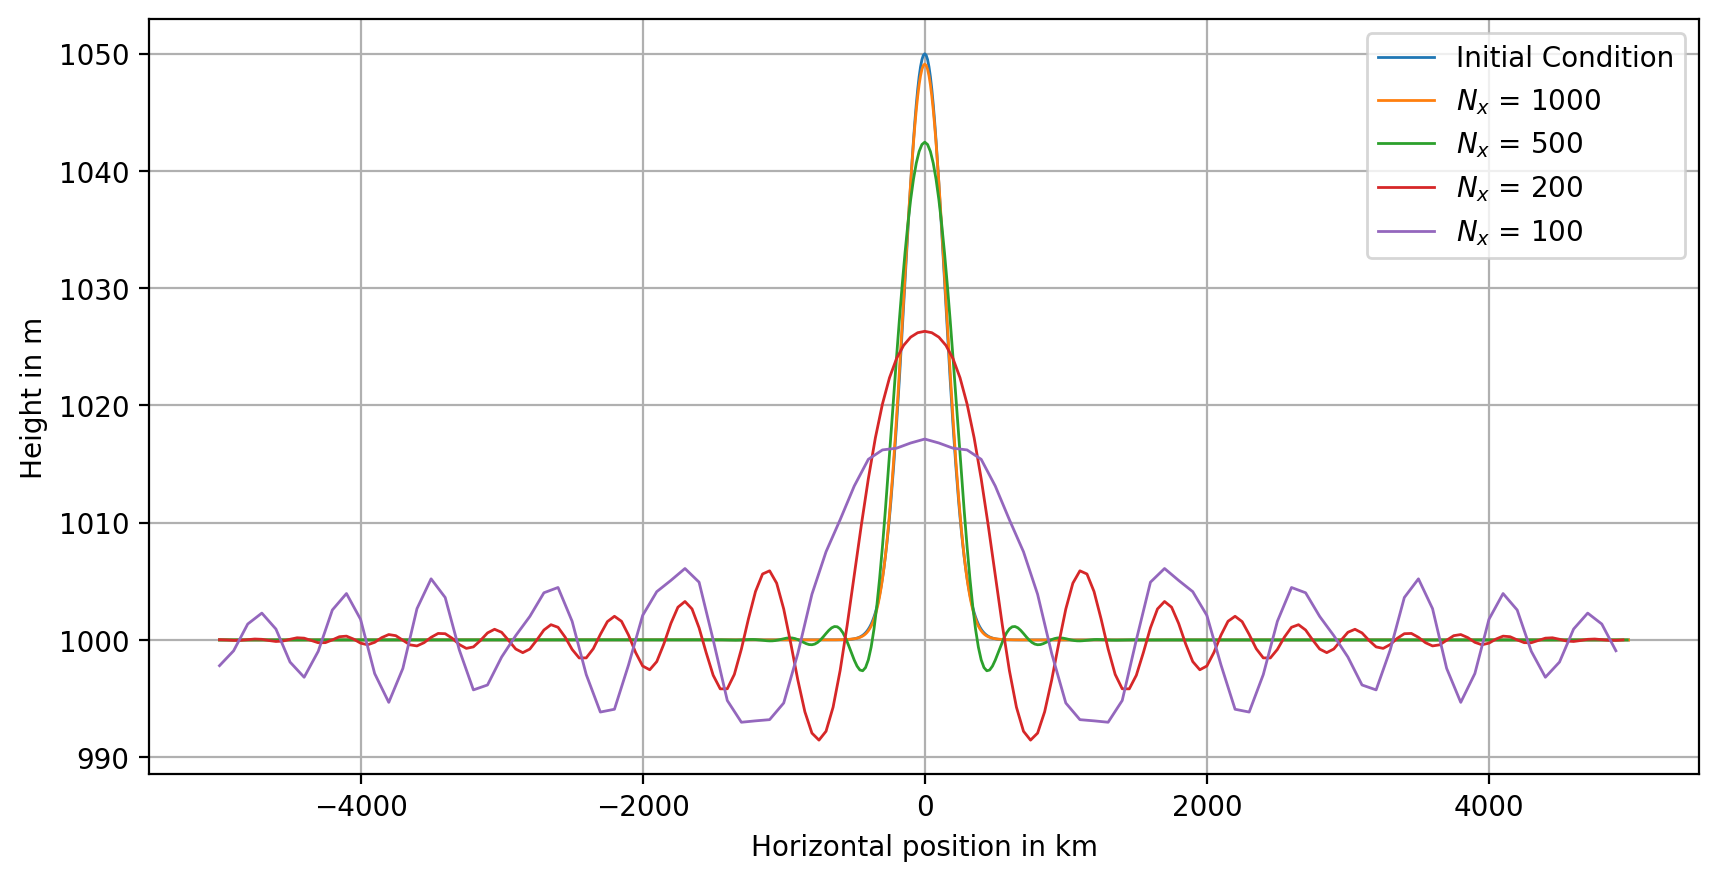

In [42]:
# constant dt=50s
for idx, x_arr in enumerate(x_arr_c):
    if idx == 0:
        plt.plot(x_arr / 1e3, h_arr_c[idx][0], label="Initial Condition")
    plt.plot(x_arr / 1e3, h_arr_c[idx][-1], label=f"$N_x$ = {int(L/dx_arr_c[idx])}")

plt.legend()
plt.grid(True)
plt.xlabel("Horizontal position in km")
plt.ylabel("Height in m")

Text(0, 0.5, 'Height in m')

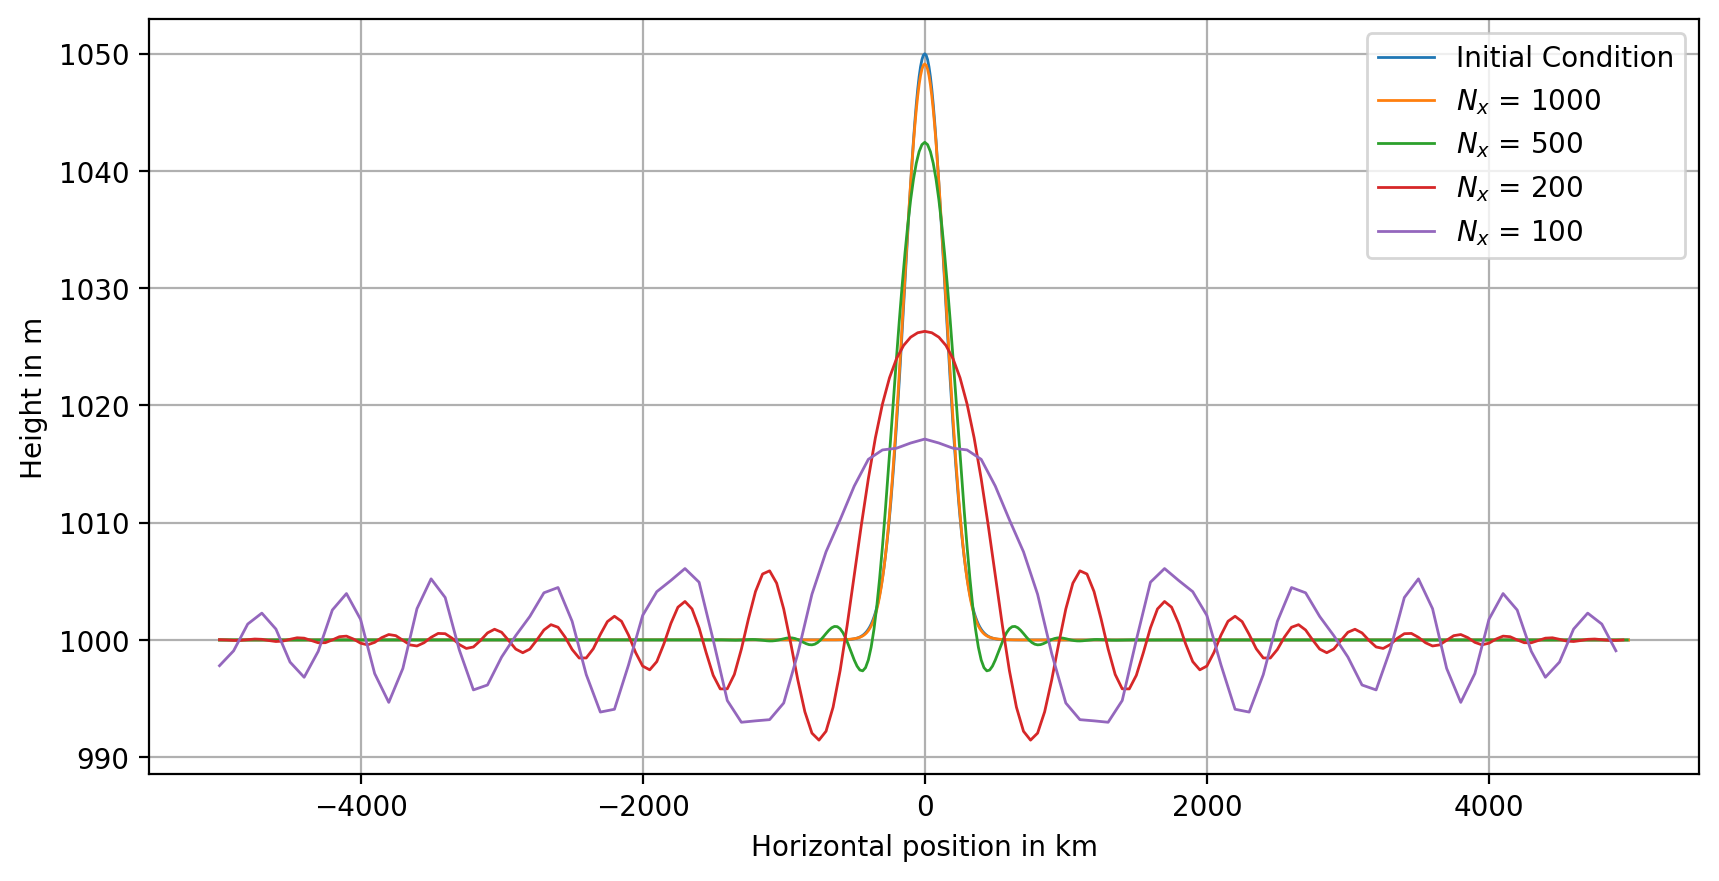

In [43]:
# constant dt=50s
for idx, x_arr in enumerate(x_arr_c):
    if idx == 0:
        plt.plot(x_arr / 1e3, hmats_arr_c[idx][0], label="Initial Condition")
    plt.plot(x_arr / 1e3, hmats_arr_c[idx][-1], label=f"$N_x$ = {int(L/dx_arr_c[idx])}")

plt.legend()
plt.grid(True)
plt.xlabel("Horizontal position in km")
plt.ylabel("Height in m")

In [44]:
# varying delta t: anwer to d)

# Numerics Parameters
dx = 20000 #s
x_arr = np.arange(-L/2, L/2, dx) #Periodic boundaries so no L+dx

dt_arr_d = [50, 20, 10] # m, 100-1000 gridpoints
u_arr_d = []
h_arr_d = []

#Initialising arrays
for dt in dt_arr_d:
    t_arr = np.arange(0, T + dt, dt)
    
    #Initial speed and height profile
    u0 = np.zeros(len(x_arr))
    h0 = np.zeros(len(x_arr))
    h0[x_arr < -5000e3] = H
    h0[x_arr >= -5000e3] = H + eta0 * np.exp(-(x_arr[x_arr >= -5000e3]/a0)**2)
    h0[x_arr > 5000e3]= H
    
    u, h = do_fin_diff(u0,h0,dt,dx, t_arr, x_arr)
    
    u_arr_d.append(u)
    h_arr_d.append(h)

Text(0, 0.5, 'Height in m')

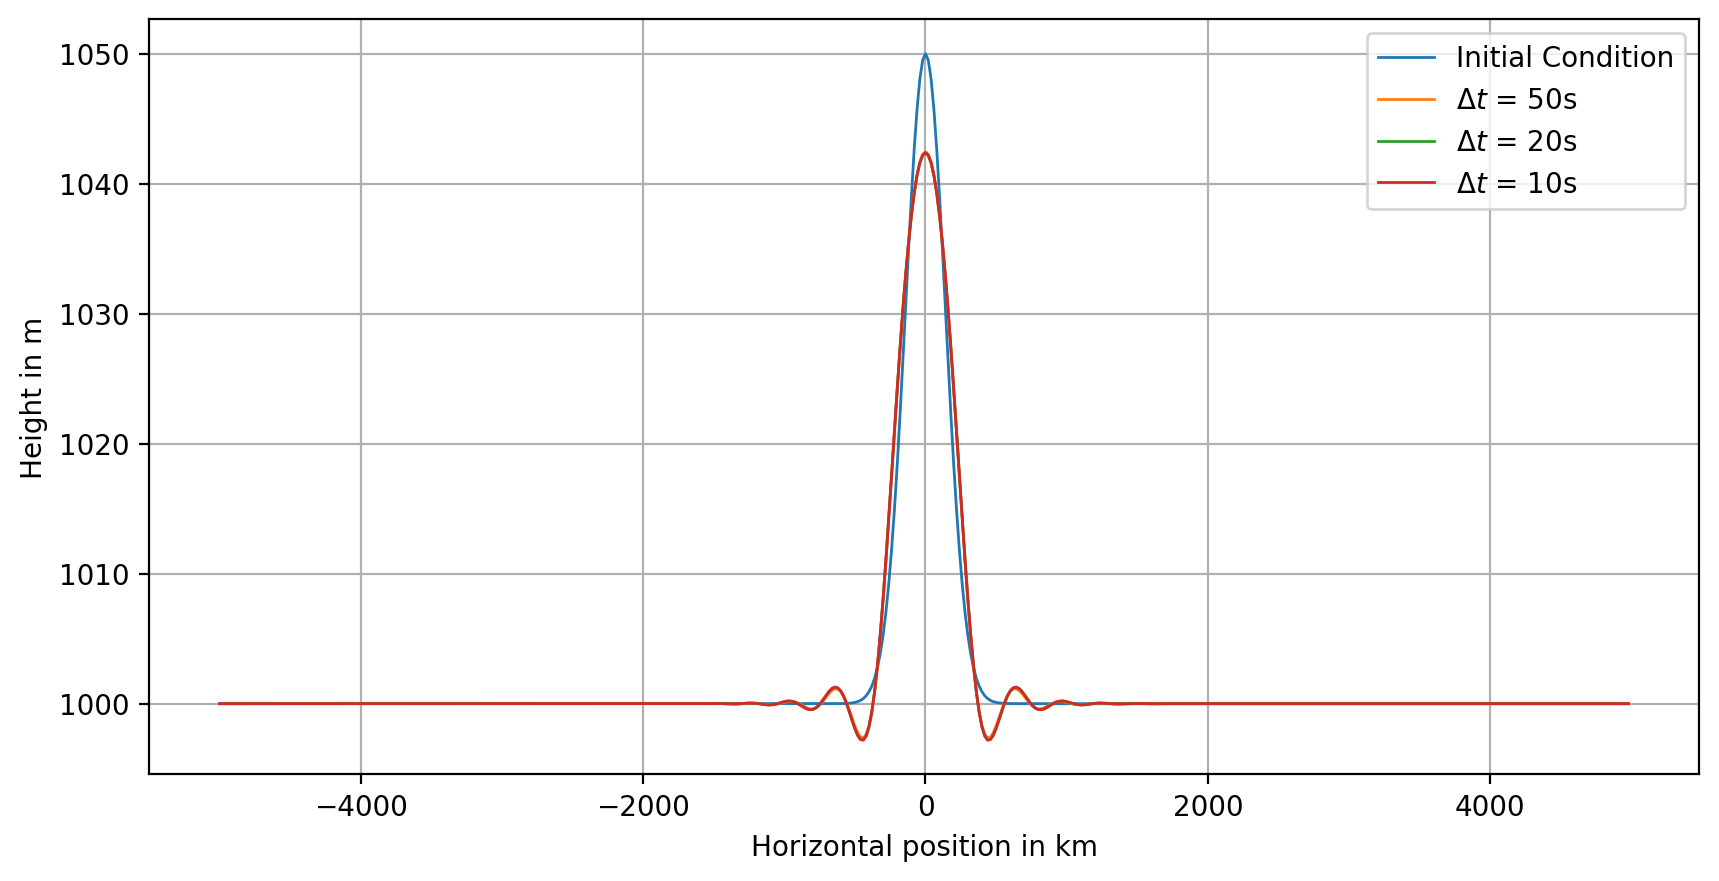

In [45]:
# constant Nx = 500 --> changing time steps does not improve anything
for idx, dt in enumerate(dt_arr_d):
    if idx == 0:
        plt.plot(x_arr / 1e3, h_arr_d[idx][0], label="Initial Condition")
    plt.plot(x_arr / 1e3, h_arr_d[idx][-1], label=f"$\Delta t$ = {dt}s")

plt.legend()
plt.grid(True)
plt.xlabel("Horizontal position in km")
plt.ylabel("Height in m")

#So dt=50 and dt=20 s overlap with the initial conditions, meaning decreasing timestep beyon dt=50 is not needed, it even leads
#to a larger error in the case of dt=10 s...Error at each point and propagates further because more points? Estimation over
#smaller timestep did not decrease error. 

In [46]:
# functions for staggered grid
def fin_diff_stag(u01, u11, u12, h01_5, h10_5 ,h11_5, dt, dx):
    '''
    C-time-space
    start both at index 1
    '''
    u21 = u01 - 2 * g * dt * ((h11_5-h10_5)/dx)
    h21_5 = h01_5 - 2 * H * dt * ((u12-u11)/dx) # u12-u11?
    return u21, h21_5

def do_fin_diff_stag(u0,h0,dt,dx, t_arr, x_arr):
    u=np.zeros((len(t_arr), len(x_arr)))
    h=np.zeros((len(t_arr), len(x_arr)))
    u[0] = u0
    h[0] = h0
    
    # initialize just no movement at beginning
    u[1] = u0
    h[1] = h0
    
    for tidx, (ut, ht) in enumerate(zip(u,h)):
        if tidx == len(u)-1:
            break
        if tidx == 0: 
            continue # first is set by initial conditions
        for xidx, (ux, hx) in enumerate(zip(ut,ht)):
            
            # values at time step and position
            u11 = ux
            h11_5 = hx
            
            # value at same time step but one position further
            if xidx == len(ut)-1:
                u12 = u[tidx,0]
            else:
                u12 = u[tidx, xidx+1]
            
            # value at same time step but one position before
            h10_5 = h[tidx, xidx-1]           
            
            # values at same point but one time step earlier
            u01 = u[tidx-1, xidx]
            h01_5 = h[tidx-1, xidx]
            
            u21, h21_5 = fin_diff_stag(u01, u11, u12, h01_5, h10_5 ,h11_5, dt, dx)
            u[tidx+1,xidx] = u21
            h[tidx+1,xidx] = h21_5

            
            #u21, h21_5 = fin_diff_stag(u10,u01,u12,h10_5,h01_5,h12_5,dt,dx)
            #u[tidx+1,xidx] = u21
            #h[tidx+1,xidx] = h21_5
            
    return u,h

In [47]:
# using staggered grid + varying grid point amount: answer to e)

# Numerics Parameters
dt = 50 #s
t_arr = np.arange(0, T + dt, dt)

dx_arr_e = [10000, 20000, 50000, 100000] # m, 100-1000 gridpoints
u_arr_e = []
h_arr_e = []
x_arr_e = []

#Initialising arrays
for dx in dx_arr_e:
    x_arr = np.arange(-L/2, L/2, dx) #Periodic boundaries so no L+dx
    #Initial speed and height profile
    x_arr_e.append(x_arr)
    u0 = np.zeros(len(x_arr))
    h0 = np.zeros(len(x_arr))
    h0[x_arr < -5000e3] = H
    h0[x_arr >= -5000e3] = H + eta0 * np.exp(-(x_arr[x_arr >= -5000e3]/a0)**2)
    h0[x_arr > 5000e3]= H
    
    u, h = do_fin_diff_stag(u0,h0,dt,dx, t_arr, x_arr)
    u_arr_e.append(u)
    h_arr_e.append(h)
    #x_arr_e.append(x_arr)

Text(0, 0.5, 'Height in m')

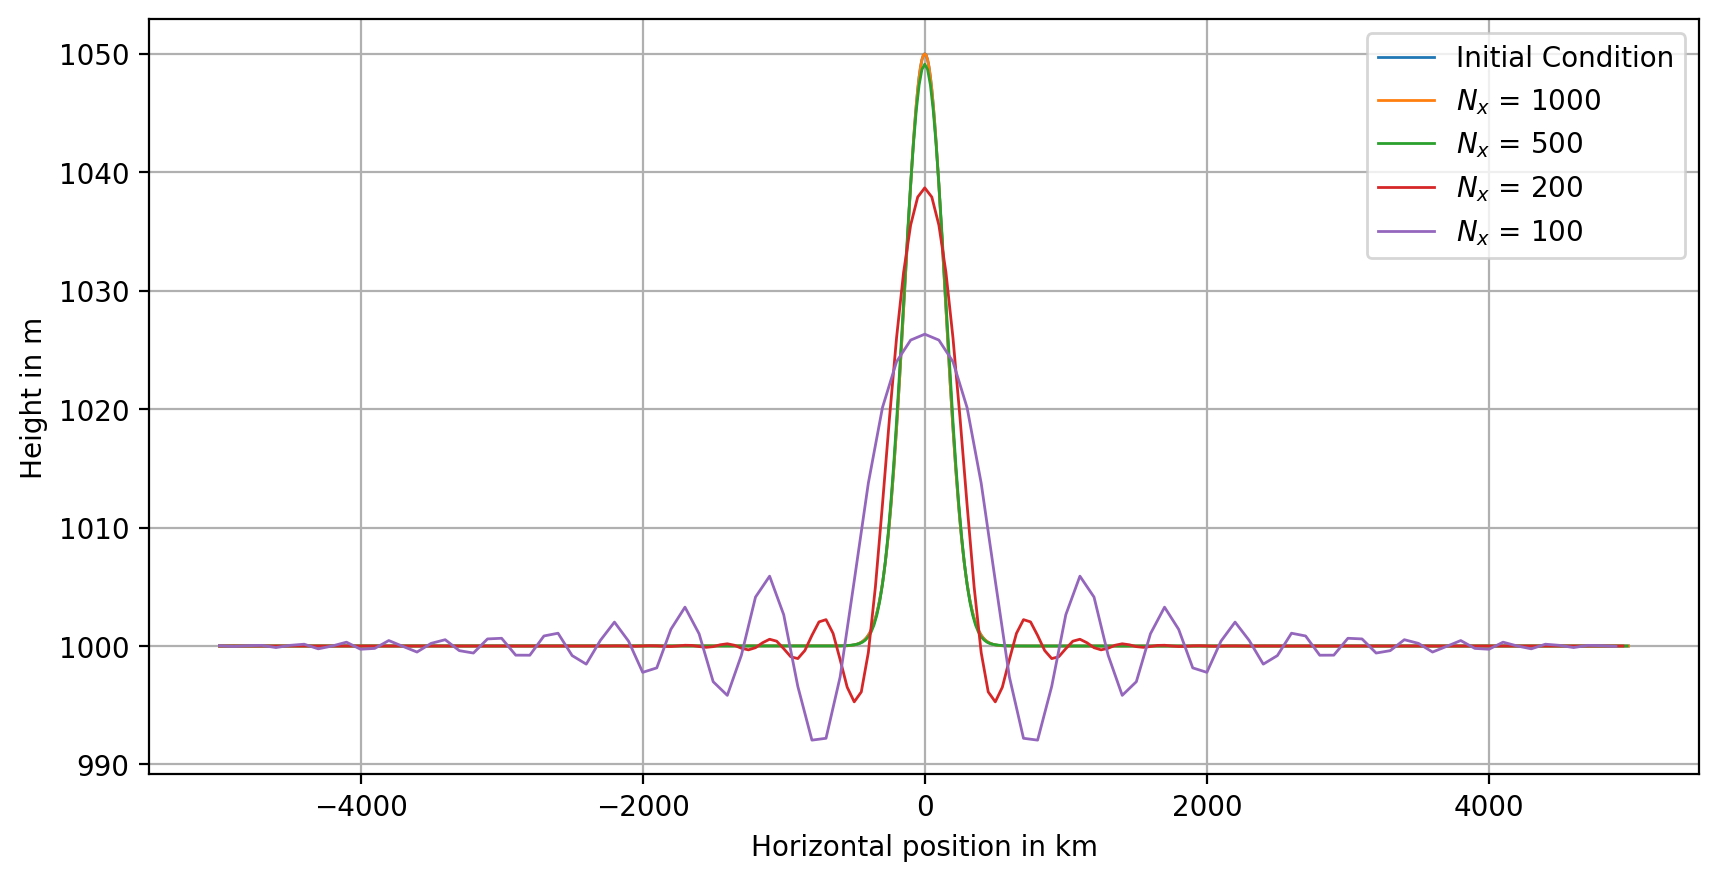

In [48]:
# constant dt=50s
'''
Watch out with the grid:
u and h do not have the same grid anymore. 
The way it is implemented here to have the usual grid for h and u is moved by dx/2 to the left.
But so far we only plot h so doesn't really matter...
'''
for idx, x_arr in enumerate(x_arr_e):
    if idx == 0:
        plt.plot(x_arr / 1e3, h_arr_e[idx][0], label="Initial Condition")
    plt.plot(x_arr / 1e3, h_arr_e[idx][-1], label=f"$N_x$ = {int(L/dx_arr_e[idx])}")

plt.legend()
plt.grid(True)
plt.xlabel("Horizontal position in km")
plt.ylabel("Height in m")

In [49]:
# varying delta t: anwer to d)

# Numerics Parameters
dx = 20000 #s
x_arr = np.arange(-L/2, L/2, dx) #Periodic boundaries so no L+dx

dt_arr_e = [50, 20, 10] # m, 100-1000 gridpoints
u_arr_e = []
h_arr_e = []

#Initialising arrays
for dt in dt_arr_e:
    t_arr = np.arange(0, T + dt, dt)
    
    #Initial speed and height profile
    u0 = np.zeros(len(x_arr))
    h0 = np.zeros(len(x_arr))
    h0[x_arr < -5000e3] = H
    h0[x_arr >= -5000e3] = H + eta0 * np.exp(-(x_arr[x_arr >= -5000e3]/a0)**2)
    h0[x_arr > 5000e3]= H
    
    u, h = do_fin_diff_stag(u0,h0,dt,dx, t_arr, x_arr)
    
    u_arr_e.append(u)
    h_arr_e.append(h)

Text(0, 0.5, 'Height in m')

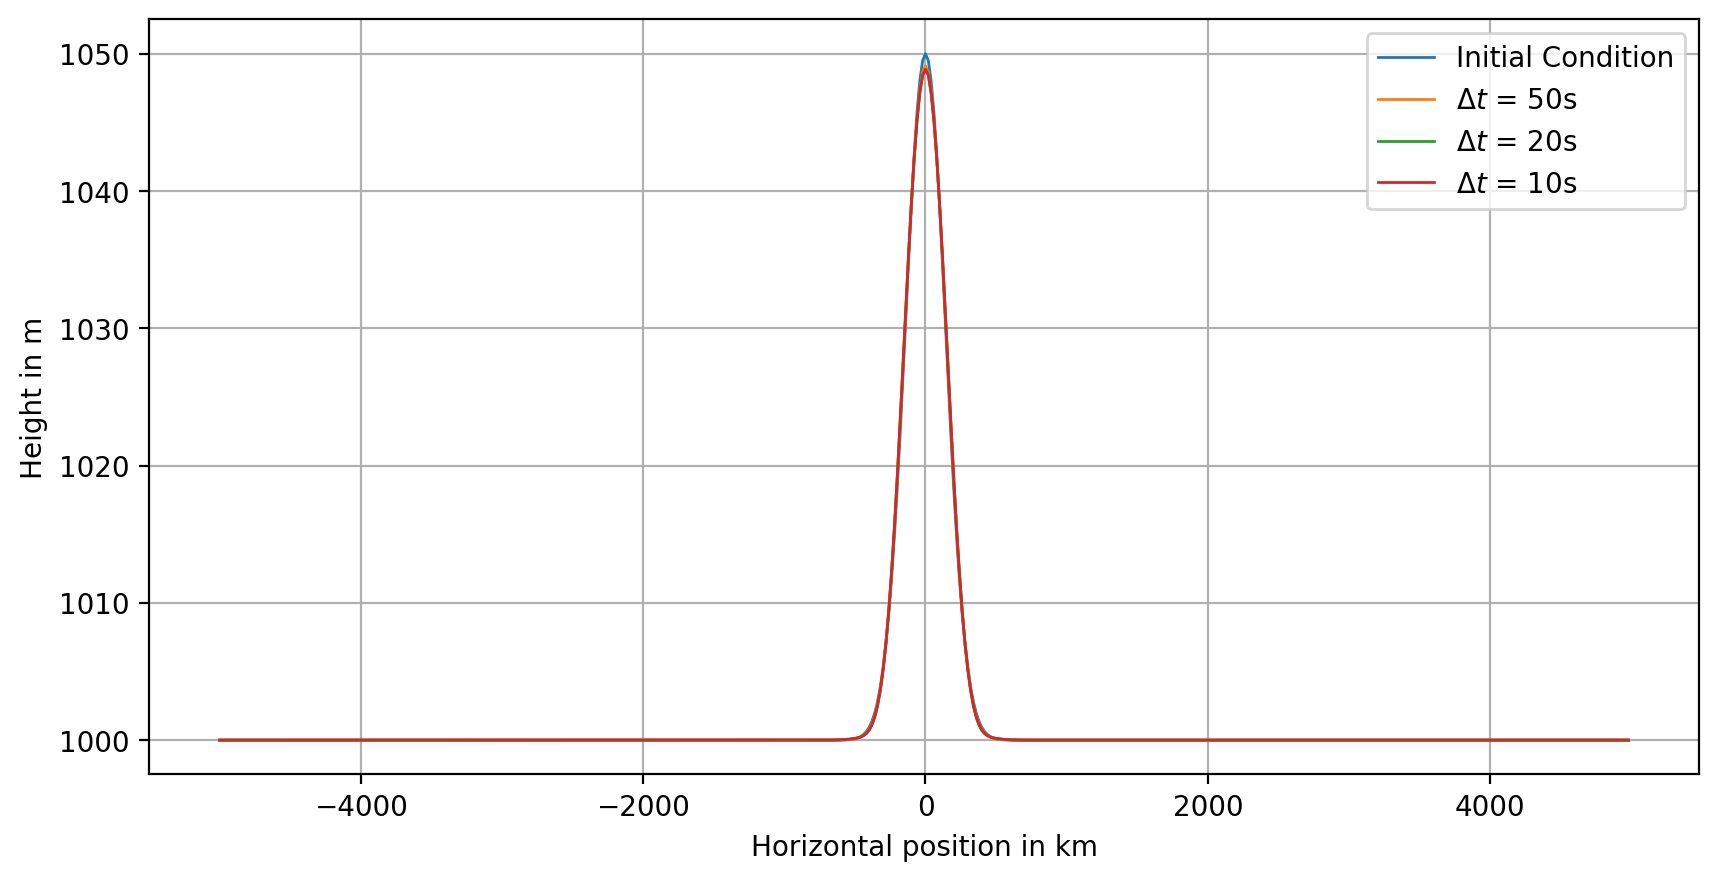

In [50]:
# constant Nx = 500 --> changing time steps does not improve anything
for idx, dt in enumerate(dt_arr_e):
    if idx == 0:
        plt.plot(x_arr / 1e3, h_arr_e[idx][0], label="Initial Condition")
    plt.plot(x_arr / 1e3, h_arr_e[idx][-1], label=f"$\Delta t$ = {dt}s")

plt.legend()
plt.grid(True)
plt.xlabel("Horizontal position in km")
plt.ylabel("Height in m")